# Implementing Temperature Scaling for a Heteroskedastic Regressor

In the classification literature, a technique called temperature scaling is often used to calibrate deep networks by rescaling model logits before the softmax operation to reflect a more accurate categorical distribution on the ground truth class of an input. To my knowledge, no analogous technique exists for heteroscedastic regression models.

I propose the following post-training procedure to calibrate a heteroscedastic network (assuming the regressor outputs some concept of a mean / loc and a variance / scale):

### Regression Temperature Scaling
Let $f(x | \Theta)$ be some trained heteroscedastic neural network with parameters $\Theta$, where $ f_{| \Theta}: X \rightarrow (\mu, \sigma)$ parametrizes a probability distribution on the regression target.

We seek $f'(x | \Theta): X \rightarrow (\mu, \tau \sigma)$, where $\tau$ is learned on some hold-out validation set and universally up/downscales the model's predicted uncertainty in a way that increases its calibration.

In [1]:
import sys
sys.path.append("../..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from scipy.optimize import minimize_scalar
from scipy.stats import norm
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from deep_uncertainty.evaluation.calibration import (compute_average_calibration_score,
                                    plot_regression_calibration_curve)
from deep_uncertainty.models.regressors import GaussianDNN
from deep_uncertainty.toy.gen_data import generate_gaussian_data
from deep_uncertainty.utils.model_utils import evaluate_gaussian_dnn, train_gaussian_dnn

### Helper Functions

In [3]:
def gaussian_nll(targets, mean, logvar):
    return 0.5 * (torch.exp(-logvar) * (targets - mean)**2 + logvar).mean()

def parametrized_gaussian_nll(targets, mean, logvar, tau):
    """NLL for Gaussian with standard deviation of (tau * sigma)."""
    return 0.5 * (np.exp(-logvar - np.log(tau)) * (targets - mean)**2 + logvar).mean()

def visualize_regression_model_on_test_with_confidence_regions(test_x, test_y, posterior):
    
    test_x = test_x.squeeze()
    plt.figure(figsize=(10, 6))
    plt.scatter(test_x, test_y, alpha=0.1, label="Generated Data")
    plt.plot(test_x, posterior.kwds['loc'], label="Predicted Mean", color='r', linestyle='-', linewidth=2)
    plt.fill_between(test_x, posterior.ppf(0.025), posterior.ppf(0.972), color='r', alpha=0.2, label="95% confidence interval")

    plt.axvline(x=-5, color='g', linestyle='--', linewidth=2, label="Training Data Ends")
    plt.axvline(x=5, color='g', linestyle='--', linewidth=2)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gaussian DNN Regression')
    plt.legend()
    plt.show()

### Build Dataset

We first generate a few datasets drawn from the same distribution for training, testing, and validation.

The test distribution spans a larger input space than the training distribution. This will allow us to see how our methods perform on "out of distribution" examples.

There are two validation sets we create -- one that is drawn from the training distribution input space, and one that is drawn from the test distribution input space. The choice of validation set during weight optimization is largely irrelevant for the purposes of this notebook, but will come into play when post-hoc calibration occurs. The effect of the temperature scaling step may change depending on the validation set's similarity to the test set.

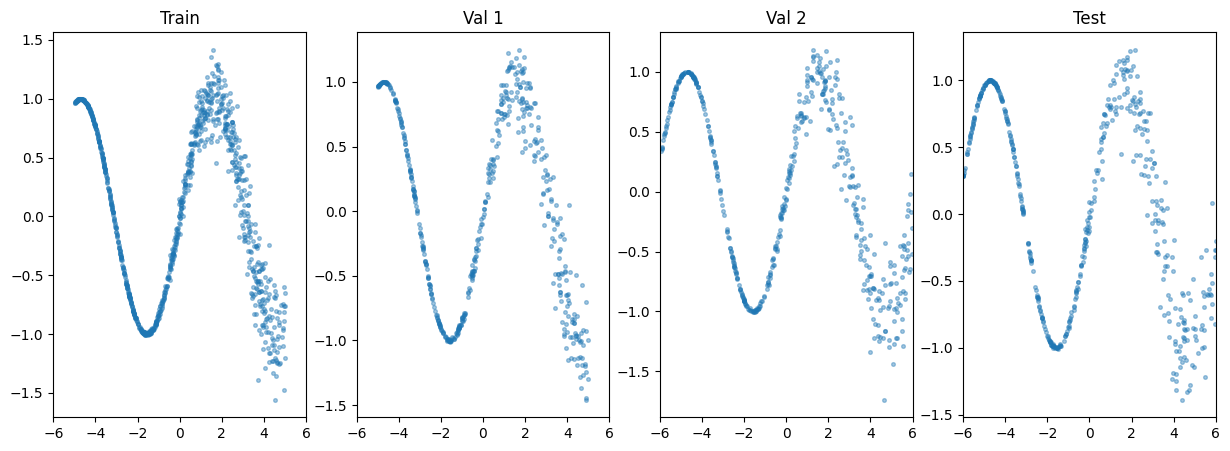

In [4]:
train_x, train_y = generate_gaussian_data(1000, x_min=-5, x_max=5)
val_1_x, val_1_y = generate_gaussian_data(500, x_min=-5, x_max=5)
val_2_x, val_2_y = generate_gaussian_data(500, x_min=-6, x_max=6)
test_x, test_y = generate_gaussian_data(500, x_min=-6, x_max=6)

# Sort test and val sets by the x input (needed for proper mean calibration calculation and confidence interval plotting).
test_order = np.argsort(test_x)
val_1_order = np.argsort(val_1_x)
val_2_order = np.argsort(val_2_x)
test_x, test_y = test_x[test_order], test_y[test_order]
val_1_x, val_1_y = val_1_x[val_1_order], val_1_y[val_1_order]
val_2_x, val_2_y = val_2_x[val_2_order], val_2_y[val_2_order]

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].set_title("Train")
axs[0].scatter(train_x, train_y, alpha=0.4, s=7)

axs[1].set_title("Val 1")
axs[1].scatter(val_1_x, val_1_y, alpha=0.4, s=7)

axs[2].set_title("Val 2")
axs[2].scatter(val_2_x, val_2_y, alpha=0.4, s=7)

axs[3].set_title("Test")
axs[3].scatter(test_x, test_y, alpha=0.4, s=7)

[ax.set_xlim(-6, 6) for ax in axs]
plt.show()

As expected, the test set contains some "out of distribution" examples that are not seen in any other dataset besides `val-2`.

In [5]:
train_x = torch.tensor(train_x, dtype=torch.float32).unsqueeze(1)
train_y = torch.tensor(train_y, dtype=torch.float32).unsqueeze(1)
test_x = torch.tensor(test_x, dtype=torch.float32).unsqueeze(1)
test_y = torch.tensor(test_y, dtype=torch.float32).unsqueeze(1)
val_1_x = torch.tensor(val_1_x, dtype=torch.float32).unsqueeze(1)
val_1_y = torch.tensor(val_1_y, dtype=torch.float32).unsqueeze(1)
val_2_x = torch.tensor(val_2_x, dtype=torch.float32).unsqueeze(1)
val_2_y = torch.tensor(val_2_y, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)
val_1_dataset = TensorDataset(val_1_x, val_1_y)
val_2_dataset = TensorDataset(val_2_x, val_2_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_1_loader = DataLoader(val_1_dataset, batch_size=32, shuffle=False)
val_2_loader = DataLoader(val_2_dataset, batch_size=32, shuffle=False)

### Train Gaussian heteroscedastic regressor on dataset

We now train a heteroscedastic regression neural network using the Gaussian NLL to fit to the training distribution.

Training Gaussian DNN:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training Gaussian DNN: 100%|██████████| 500/500 [00:10<00:00, 48.86epoch/s, Train Loss=-2.4703, Val Loss=-2.3161]


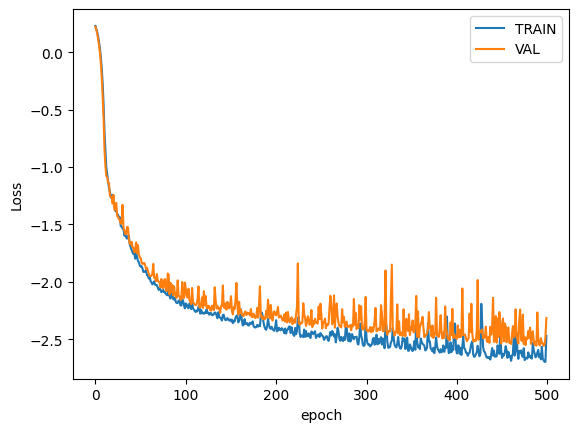

In [6]:
lr = 1e-4
num_epochs = 500

gaussian_dnn_model = GaussianDNN()
optimizer = Adam(gaussian_dnn_model.parameters(), lr=lr)
progress_bar = tqdm(range(num_epochs), desc="Training Gaussian DNN", unit="epoch")
trn_losses = []
val_losses = []
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for epoch in progress_bar:
    train_loss = train_gaussian_dnn(train_loader, gaussian_dnn_model, optimizer, device)
    val_loss = evaluate_gaussian_dnn(val_1_loader, gaussian_dnn_model, device)
    
    trn_losses.append(train_loss)
    val_losses.append(val_loss)
    
    progress_bar.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

plt.plot(np.arange(num_epochs), trn_losses, label='TRAIN')
plt.plot(np.arange(num_epochs), val_losses, label='VAL')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Visualize Results

To see how well the model fits to out-of-distribution examples, we now visualize it as a probability distribution over the test inputs/outputs, with 95% confidence intervals pictured to show how the model's uncertainty maps to the test set.

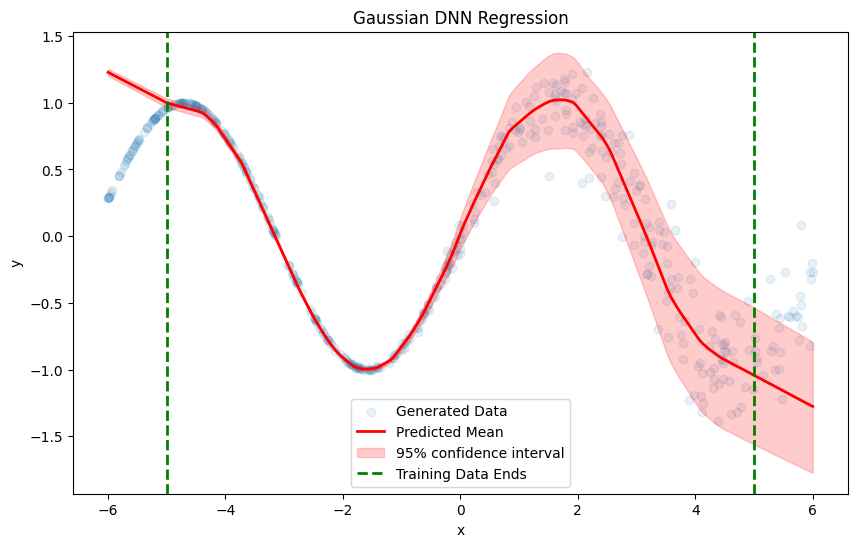

In [7]:
mu_hats, logvar_hats = gaussian_dnn_model(test_x)
mu_hats = mu_hats.squeeze().detach().numpy()
stdev_hats = np.sqrt(np.exp(logvar_hats.squeeze().detach().numpy()))
posterior = norm(loc=mu_hats, scale=stdev_hats)

visualize_regression_model_on_test_with_confidence_regions(test_x, test_y, posterior)

This particular form of heteroscedastic regression, when not exposed to the full distribution for a general context, fails to capture the growing uncertainty inherent in the ground truth distribution. This can be seen by the error bars failing to encapsulate all test outputs as x tends to -6 and 6.

We now take another view at the probabilistic calibration of our trained model by looking at a calibration curve (also known as a reliability diagram).

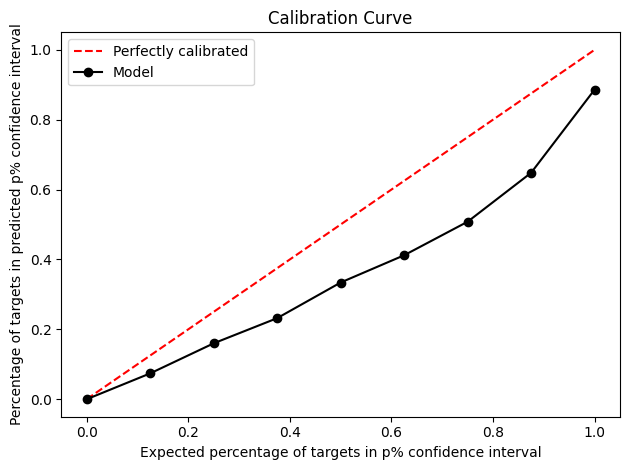

In [8]:
plot_regression_calibration_curve(test_y.squeeze().detach().numpy(), posterior)

In [10]:
compute_average_calibration_score(test_y.squeeze().detach().numpy(), posterior)

0.6990283451354957

The model appears to be overconfident in general, with uncertainty estimates that fail to fully represent the true spread of data. This motivates a post-hoc "re-scaling" of the uncertainty to see if we can do better.

### Post-hoc Calibration with Gaussian NLL

Our first attempt at re-scaling seeks to learn $\tau$ by using a Gaussian NLL loss over a "hold-out" validation set. A visualization of this objective function (dependent on $\tau$ can be seen below):

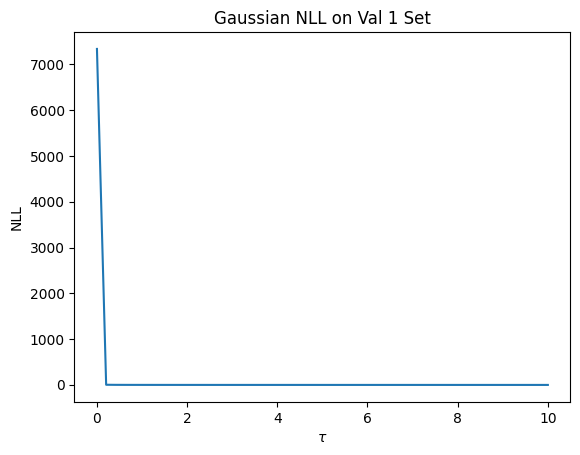

In [19]:
tau_vals = np.linspace(1e-4, 10)

targets = val_1_y.squeeze().detach().numpy()
predicted_means, predicted_logvars = gaussian_dnn_model(val_1_x)
predicted_means, predicted_logvars = predicted_means.squeeze().detach().numpy(), predicted_logvars.squeeze().detach().numpy()

plt.title("Gaussian NLL on Val 1 Set")
plt.xlabel("$\\tau$")
plt.ylabel("NLL")
plt.plot(tau_vals, [parametrized_gaussian_nll(targets, predicted_means, predicted_logvars, tau) for tau in tau_vals])
plt.show()

Barring some mistake in my implementation of the Gaussian NLL (with rescaled parametrized variance), we are left with a nonconvex optimization problem that will always encourage $\tau$ to be as large as possible.

In [14]:
result = minimize_scalar(lambda tau: parametrized_gaussian_nll(targets, predicted_means, predicted_logvars, tau), bounds=[1e-4, 2])
tau = result.x
print(f"Learned value of tau on validation set: {tau}")

mu_hats, logvar_hats = gaussian_dnn_model(test_x)
mu_hats = mu_hats.squeeze().detach().numpy()
stdev_hats = tau * np.sqrt(np.exp(logvar_hats.squeeze().detach().numpy()))

calibrated_posterior = norm(loc=mu_hats, scale=stdev_hats)

Learned value of tau on validation set: 1.9999940406382226


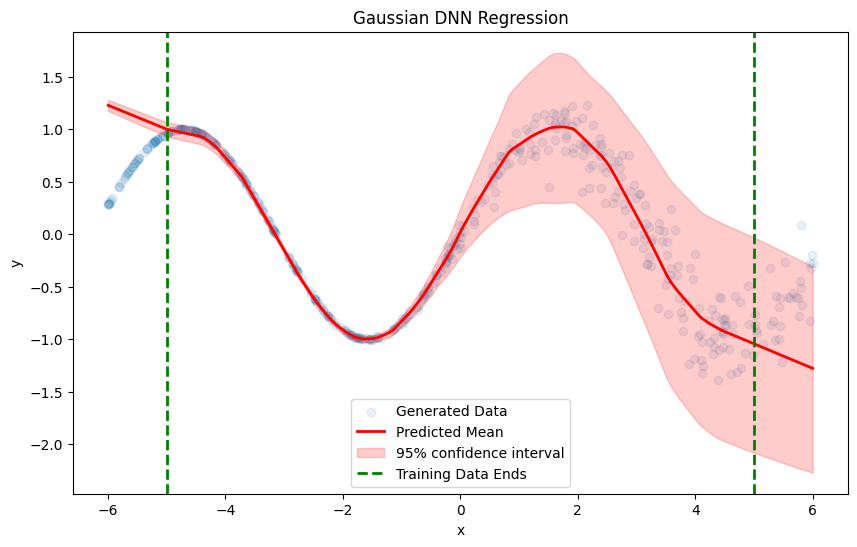

In [15]:
visualize_regression_model_on_test_with_confidence_regions(test_x, test_y, calibrated_posterior)

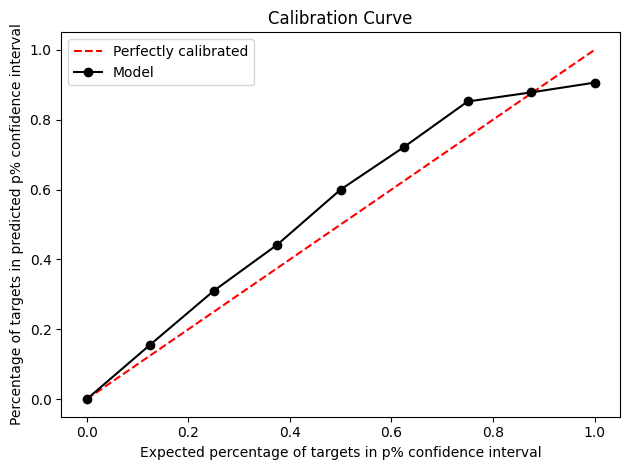

Mean calibration when tuned on validation set: 0.8746035092757638


In [17]:
plot_regression_calibration_curve(test_y.squeeze().detach().numpy(), calibrated_posterior)
average_calibration = compute_average_calibration_score(test_y.squeeze().detach().numpy(), calibrated_posterior)
print(f"Mean calibration when tuned on validation set: {average_calibration}")

Even though $\tau$ is encouraged to be as large as possible, when it is bounded, the model's performance improves. Let's see if this whole process gets better when we use the validation set that is more similar to the test set.

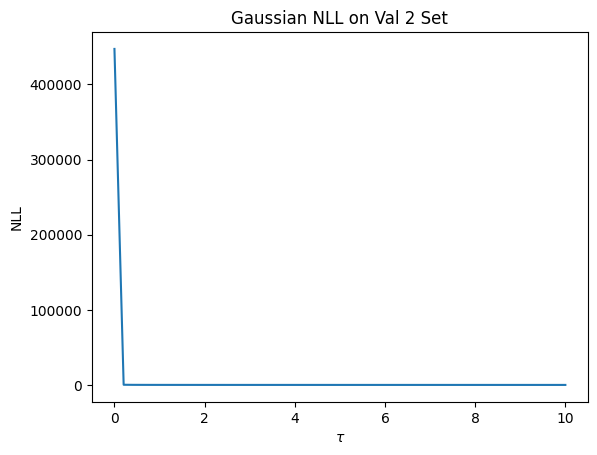

In [20]:
tau_vals = np.linspace(1e-4, 10)

targets = val_2_y.squeeze().detach().numpy()
predicted_means, predicted_logvars = gaussian_dnn_model(val_2_x)
predicted_means, predicted_logvars = predicted_means.squeeze().detach().numpy(), predicted_logvars.squeeze().detach().numpy()

plt.title("Gaussian NLL on Val 2 Set")
plt.xlabel("$\\tau$")
plt.ylabel("NLL")
plt.plot(tau_vals, [parametrized_gaussian_nll(targets, predicted_means, predicted_logvars, tau) for tau in tau_vals])
plt.show()

Once again, we have an unbounded optimization problem. No need to carry this through to see if performance improves, since we will get an identical value of $\tau$ as with the first validation set.

### Post-hoc Calibration With Mean Calibration as Objective Function

The Gaussian NLL proved ill-suited for the task of choosing a value of $\tau$, so what if we used another objective function that still reflects our desire to calibrate the model as well as possible? The **Mean Calibration** might do the trick. Because minimization is the standard, we will seek to minimize the negative mean calibration with our value of $\tau$.

We first try with the hold-out validation set that has the same input limitations as the training set.

In [21]:
def calibration_loss(val_x, val_y, model, tau):
    predicted_mus, predicted_logvars = model(val_x)
    predicted_stdevs = tau * np.sqrt(np.exp(predicted_logvars.squeeze().detach().numpy()))
    posterior = norm(loc=predicted_mus.squeeze().detach().numpy(), scale=predicted_stdevs)
    return -compute_average_calibration_score(val_y.squeeze().detach().numpy(), posterior)

We plot the "negative loss" function to demonstrate that this is really a maximization problem.

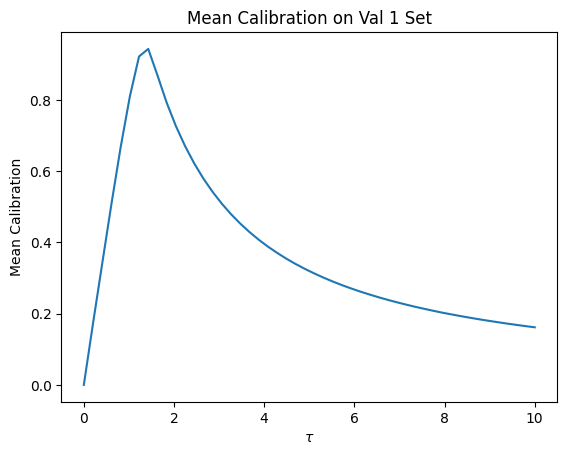

In [23]:
tau_vals = np.linspace(1e-4, 10)

plt.title("Mean Calibration on Val 1 Set")
plt.xlabel("$\\tau$")
plt.ylabel("Mean Calibration")
plt.plot(tau_vals, [-calibration_loss(val_1_x, val_1_y, gaussian_dnn_model, tau) for tau in tau_vals])
plt.show()

In [24]:
result = minimize_scalar(lambda tau: calibration_loss(val_1_x, val_1_y, gaussian_dnn_model, tau), bounds=[1e-4, 10])
tau = result.x
print(f"Learned value of tau on validation set 1: {tau}")

mu_hats, logvar_hats = gaussian_dnn_model(test_x)
mu_hats = mu_hats.squeeze().detach().numpy()
stdev_hats = tau * np.sqrt(np.exp(logvar_hats.squeeze().detach().numpy()))

calibrated_posterior = norm(loc=mu_hats, scale=stdev_hats)

Learned value of tau on validation set 1: 1.3845520942663907


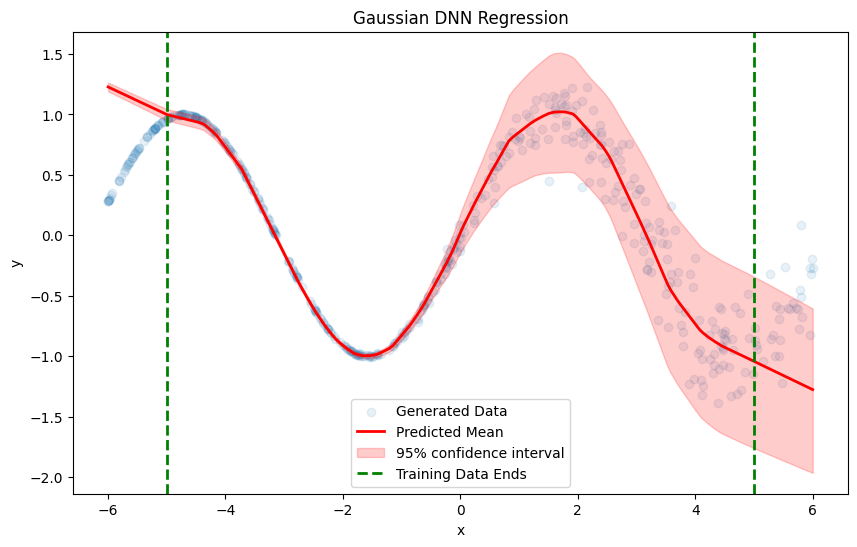

In [25]:
visualize_regression_model_on_test_with_confidence_regions(test_x, test_y, calibrated_posterior)

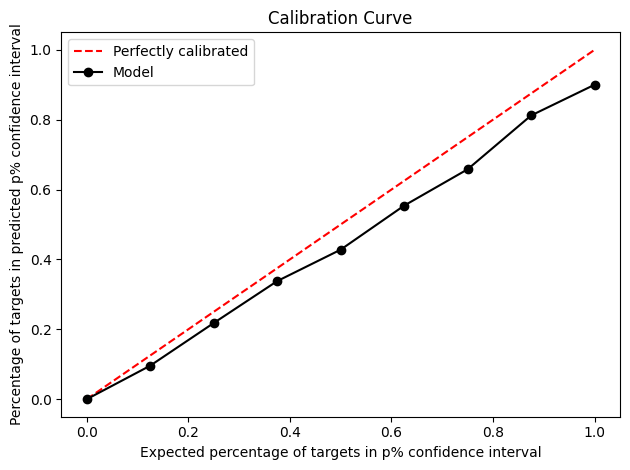

Mean calibration when tuned on validation set: 0.8883353413542948


In [26]:
plot_regression_calibration_curve(test_y.squeeze().detach().numpy(), calibrated_posterior)
average_calibration = compute_average_calibration_score(test_y.squeeze().detach().numpy(), calibrated_posterior)
print(f"Mean calibration when tuned on validation set: {average_calibration}")

The results are great! The increase in mean calibration is quite large -- 0.69 -> 0.89. This approach shows promise.

Can we do even better? What if the hold-out set were more similar in distribution to the test set?

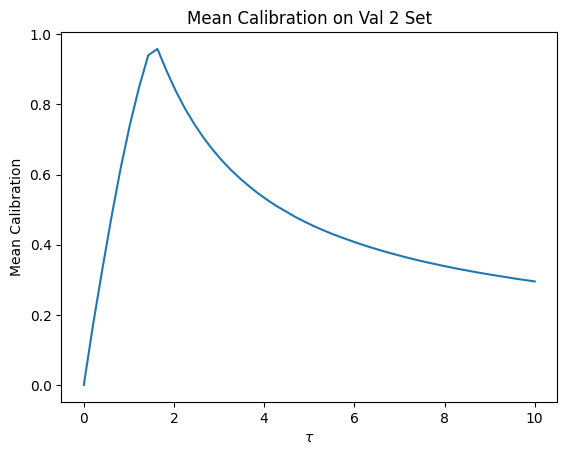

In [27]:
# Visualize objective function.

tau_vals = np.linspace(1e-4, 10)

plt.title("Mean Calibration on Val 2 Set")
plt.xlabel("$\\tau$")
plt.ylabel("Mean Calibration")
plt.plot(tau_vals, [-calibration_loss(val_2_x, val_2_y, gaussian_dnn_model, tau) for tau in tau_vals])
plt.show()

In [28]:
result = minimize_scalar(lambda tau: calibration_loss(val_2_x, val_2_y, gaussian_dnn_model, tau), bounds=[1e-4, 10])
tau = result.x
print(f"Learned value of tau: {tau}")

mu_hats, logvar_hats = gaussian_dnn_model(test_x)
mu_hats = mu_hats.squeeze().detach().numpy()
stdev_hats = tau * np.sqrt(np.exp(logvar_hats.squeeze().detach().numpy()))

calibrated_posterior = norm(loc=mu_hats, scale=stdev_hats)

Learned value of tau: 1.5541523543510647


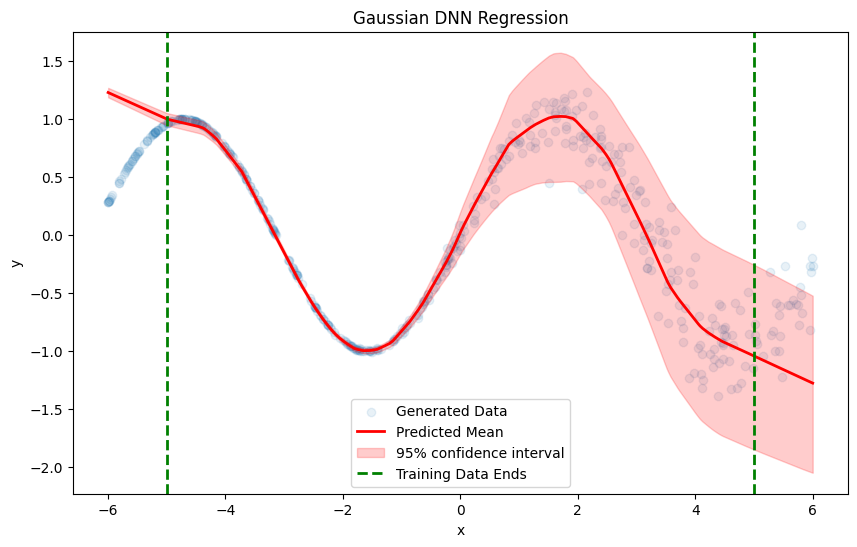

In [29]:
visualize_regression_model_on_test_with_confidence_regions(test_x, test_y, calibrated_posterior)

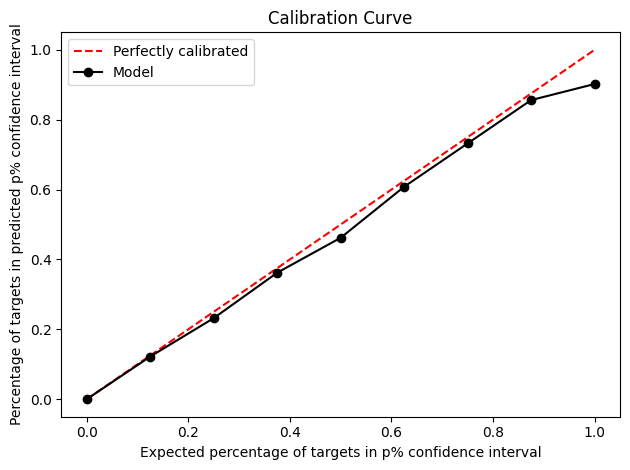

In [30]:
plot_regression_calibration_curve(test_y.squeeze().detach().numpy(), calibrated_posterior)

In [31]:
average_calibration = compute_average_calibration_score(test_y.squeeze().detach().numpy(), calibrated_posterior)
print(f"Mean calibration when tuned on validation set: {average_calibration}")

Mean calibration when tuned on validation set: 0.9563010087438307


When the hold-out set for tuning $\tau$ is similar to the test distribution, even if we trained on a smaller distribution, we can largely recover model performance.

Other techniques that are better at representing out-of-distribution samples with increased uncertainty may lend themselves to post-hoc temperature scaling even more.

### Takeaways

1. Just like with all machine learning, the data you train and tune on should be as close as possible to the ground truth distribution. This is especially true when performing post-hoc calibration on a trained neural net.
2. Even when trained on a representative sample, neural networks tend to be universally overconfident. Temperature scaling can largely resolve this issue (for both classification, which is well-documented, and regression, which is less studied).
2. Models that do well at representing out-of-distribution uncertainty, combined with temperature scaling, may achieve very good calibration.